### Laboratorium 4 - zadania

Jeśli nie posiadasz jeszcze pakietu `skimage`, zainstaluj go poniższym poleceniem:

In [1]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries, slic

#### Zadanie 1

Dane są obrazy `hare` i `pills`. Wykonaj dla nich segmentację przy użyciu algorytmu SLIC. Celem jest uzyskanie jednolitych  superpikseli, a więc zawierających tylko fragmenty obiektów lub tylko tła (a nie jednego i drugiego naraz). Przeanalizuj zachowanie algorytmu dla różnej liczby superpikseli i parametru sigma.

Zwróć uwagę, że wynikiem działania scikitowej implementacji SLIC (podobnie jak wielu innych algorytmów klasyfikacyjnych) jest obraz typu `np.int64` przyporządkowujący każdemu pikselowi obrazu wejściowego indeks superpiksela. Takiej reprezentacji oczekuje też funkcja `mark_boundaries`.

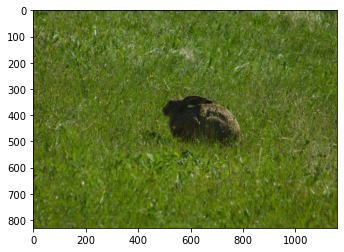

In [2]:
hare = cv2.imread('../dane-1-4/Zajac_kolor.jpg')[..., ::-1]
plt.imshow(hare)

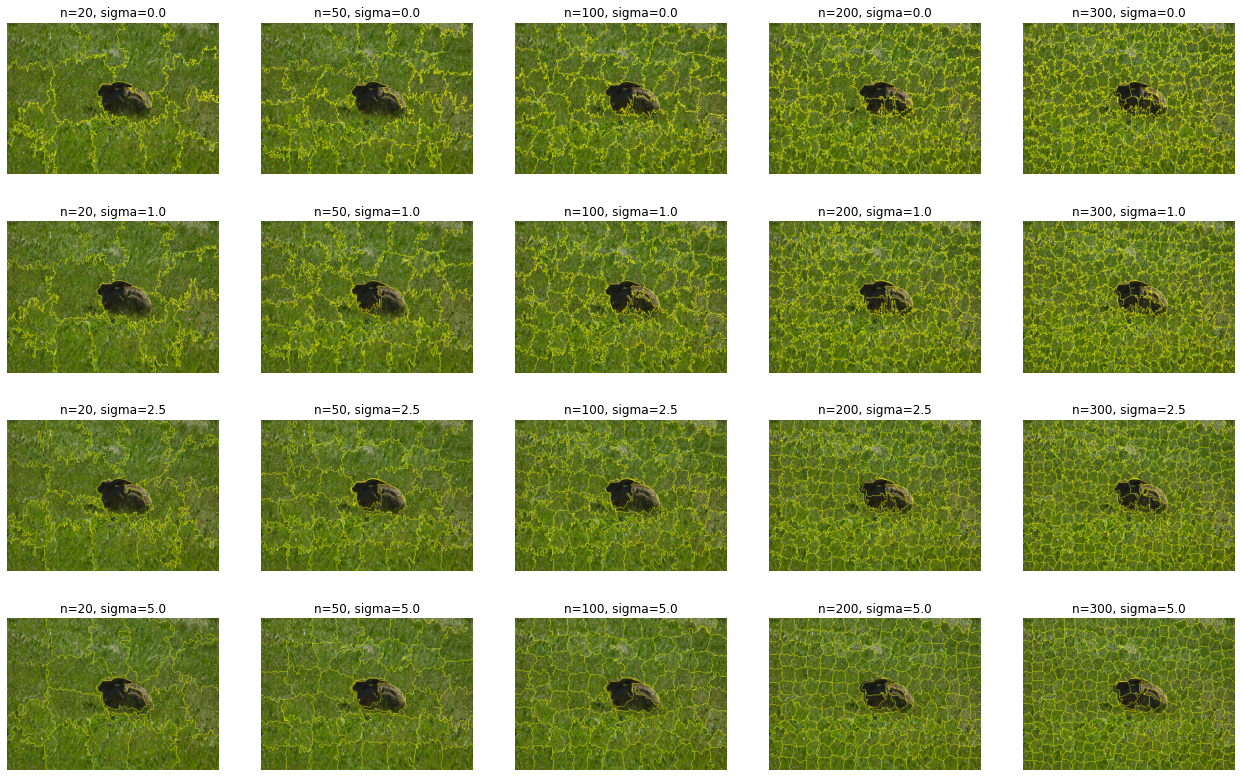

In [6]:
def plot_slics(img, data, ncols=4, nrows=5):
    fig, axes = plt.subplots(ncols, nrows, figsize=(22, 14))

    for ax, (n_segments, sigma, slic) in zip(axes.flatten(), data):
        ax.imshow(mark_boundaries(img, slic))
        ax.axis("off")
        ax.set_title(f"n={n_segments}, sigma={sigma}")

    plt.show()

data = [
    (n_segments, sigma, slic(hare, n_segments=n_segments, sigma=sigma, start_label=0))
    for sigma in [0.0, 1.0, 2.5, 5.0] for n_segments in [20, 50, 100, 200, 300]    
]
plot_slics(hare, data)

Wraz ze zwiększaniem ilości klastrów dostajemy lepsze odwzorowanie zawartości obrazu - w ramach jednego super-piksela obraz jest w miarę jednorodny, nie ma dwóch obiektów w jednym klastrze. Jednak im mniejsze super-piksele tym mniej w nich kontekstu i potencjalne cechy z nich wydobywane są bardziej zaszumione.

Ze wzrostem parametru sigma (wielkość kernela gaussa, którym jest wygładzany obraz w ramach preprocessingu), super-piksele mają bardziej regularne kształty i mniej zaszumione krawędzie. Jednak taka regularyzacja sprawia, że przy większych wartościach parametru wymuszana regularność klastrów nie pozwala im na odpowiednie dopasowanie się do krawędzi obiektów.

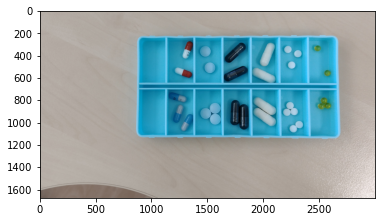

In [4]:
pills = cv2.imread('../dane-1-4/pills.png')[..., ::-1]
plt.imshow(pills)

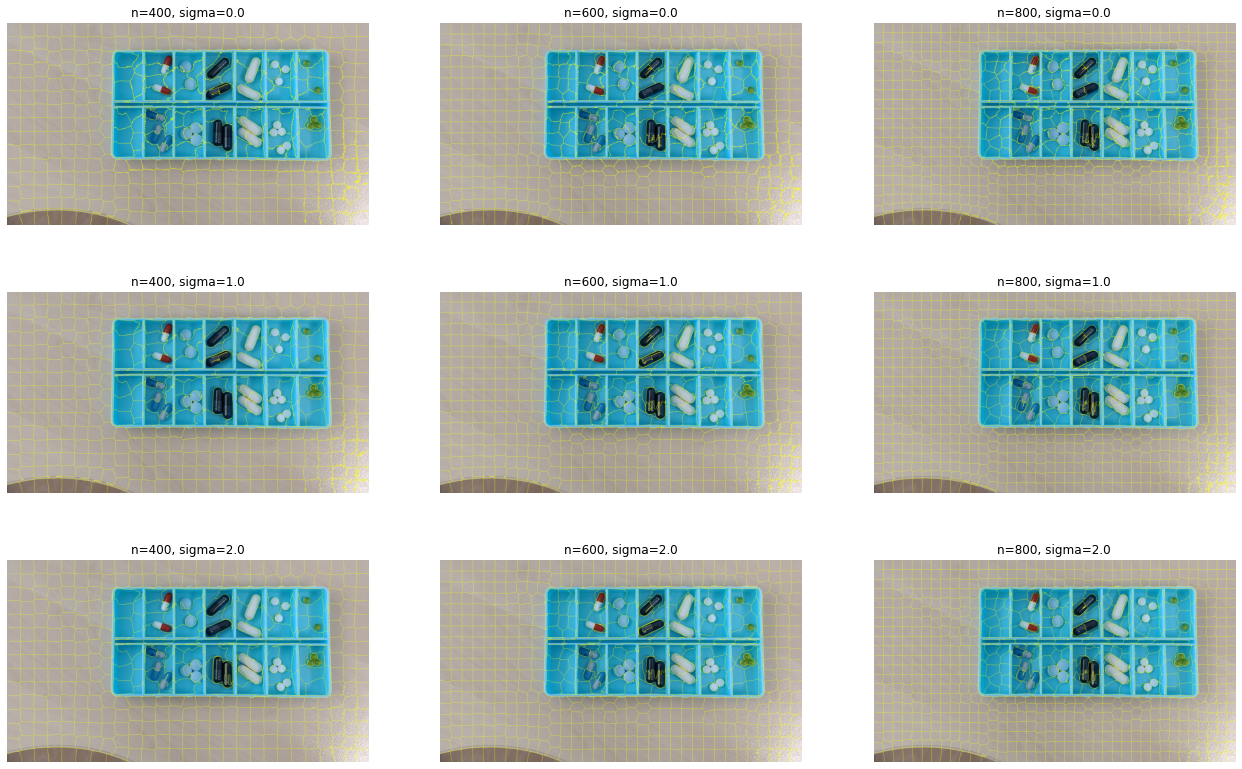

In [9]:
data = [
    (n_segments, sigma, slic(pills, n_segments=n_segments, sigma=sigma, start_label=0))
    for sigma in [0.0, 1.0, 2.0] for n_segments in [400, 600, 800]    
]
plot_slics(pills, data, 3, 3)

#### Zadanie 2

Dla obrazu `hare` wykonaj post-processing segmentacji SLIC by uzyskać dwa jednorodne obszary: jeden zawierający wyłącznie zająca, drugi zawierający wyłącznie trawę. Wykorzystaj dowolny algorytm klasteryzacji (np. `cv2.kmeans`) używając *cech* superpikseli uzyskanych w zadaniu 1 jako danych wejściowych. Najprostszymi cechami, którymi można opisać superpiksele, są np. średnie wartości składowych barwy (pikseli, z których składa się superpiksel) - od nich zacznij. Zawsze możesz rozszerzyć rozwiązanie o bardziej wyrafinowane pomysły, jeśli starczy czasu.

Zaprezentuj wyniki najlepiej za pomocą `mark_boundaries` albo po prostu wyświetlając maskę binarną.

---

NumPy pro-tip: aby uzyskać zbiór wszystkich pikseli obrazu o wartości np. 3 możesz użyć notacji: ```obraz==3```. Wynikiem jest macierz boolowska, której można używać jako selektor. Np. aby na obrazie `A` wyzerować wszystkie piksele, którym w obrazie `B` odpowiada wartość 5, możesz napisać: ```A[B==5] = 0```. Ten zapis jest **znacznie** szybszy niż manualne iterowanie po obrazach i sprawdzanie warunków if-ami.

Przykładowe użycie `cv2.kmeans` (więcej możesz poczytać np. [tutaj](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_ml/py_kmeans/py_kmeans_opencv/py_kmeans_opencv.html)):
```python
c, labels, centers = cv2.kmeans(
    data=data,  # np.ndarray typu float o wymiarach NxK gdzie N to liczba sampli (u nas: superpikseli), K - liczba cech
    K=2,        # oczekiwana liczba klastrów
    bestLabels=None,
    criteria=(cv2.TERM_CRITERIA_EPS, 10, 1.0),  # przykładowe kryteria stopu
    attempts=1, # liczba powtórzeń algorytmu
    flags=cv2.KMEANS_RANDOM_CENTERS  # sposób inicjalizacji klastrów
)
```

Funkcja ta zwraca krotkę, której najważniejszym komponentem jest ten drugi (tu: `labels`), tj. macierz o wymiarach Nx1, zawierająca indeks klastra przypisanego i-temu samplowi.

In [207]:
def slic_segmentation(img: np.array, n_segments: int, sigma: float):

    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # SLIC
    slic_img = slic(img, n_segments=n_segments, sigma=sigma, start_label=0)
    slic_segments = len(np.unique(slic_img))
    
    # Features
    features = np.array(
        [
            img[..., -1][slic_img == i].mean()
            for i in range(slic_segments)
        ]
    )

    features_slic = np.zeros_like(slic_img)
    for i in range(slic_segments):
        features_slic[slic_img==i] = features[i]

    # KMEANS
    c, labels, centers = cv2.kmeans(
        data=np.float32(features),
        K=2,
        bestLabels=None,
        criteria=(cv2.TERM_CRITERIA_EPS, 10, 1.0),
        attempts=10,
        flags=cv2.KMEANS_PP_CENTERS,
    )

    # Aggregating
    fg_components = np.argwhere(labels.flatten() == 1)
    bg_components = np.argwhere(labels.flatten() == 0)

    seg = slic_img.copy()
    seg[np.isin(slic_img, fg_components)] = 1
    seg[np.isin(slic_img, bg_components)] = 0

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(24, 30))

    # Slic
    axes[0].imshow(mark_boundaries(cv2.cvtColor(img, cv2.COLOR_HSV2BGR), slic_img))
    axes[0].axis("off")
    axes[0].set_title(f"SLIC: n={n_segments}, sigma={sigma}")

    # Feature slic
    axes[1].imshow(~features_slic)
    axes[1].axis("off")
    axes[1].set_title("Super-pixels means")

    # Segmentation
    axes[2].imshow(~seg)
    axes[2].axis("off")
    axes[2].set_title("K-means segmentation mask")

    plt.show()

    return features_slic

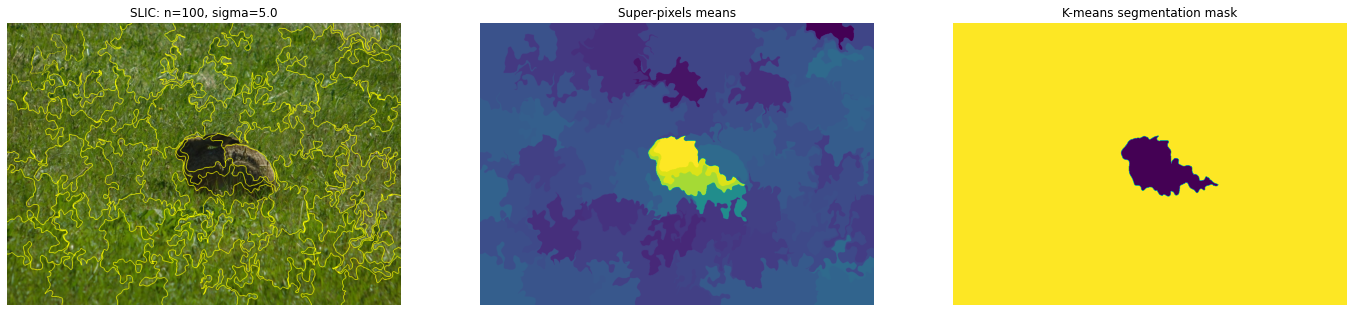

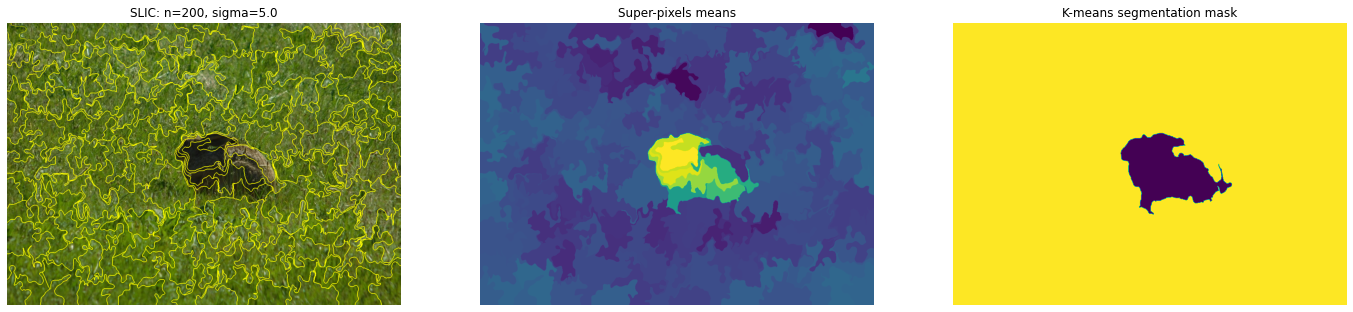

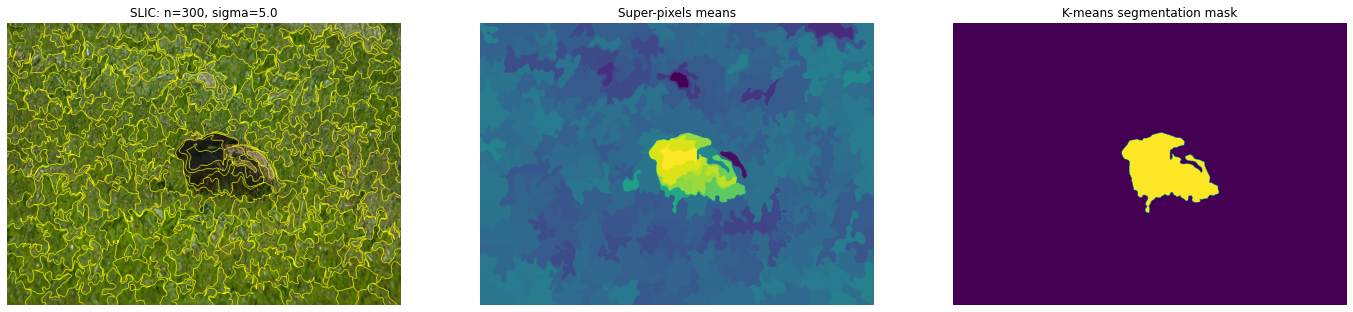

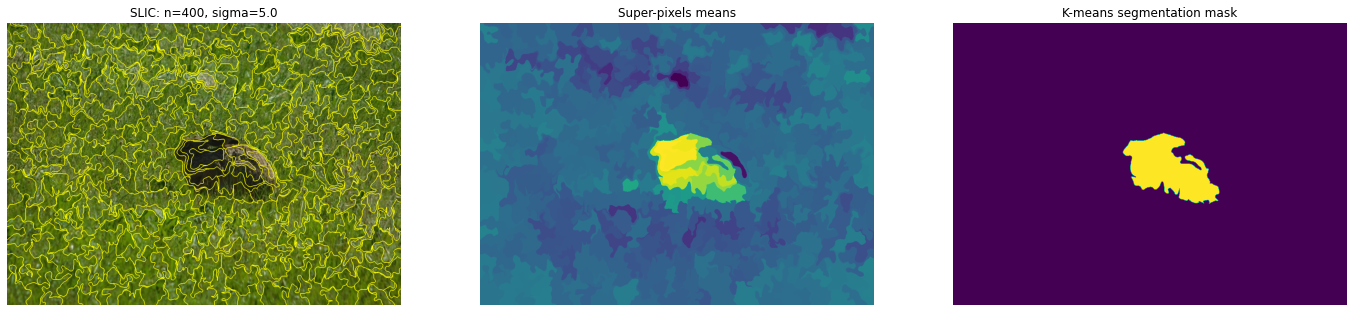

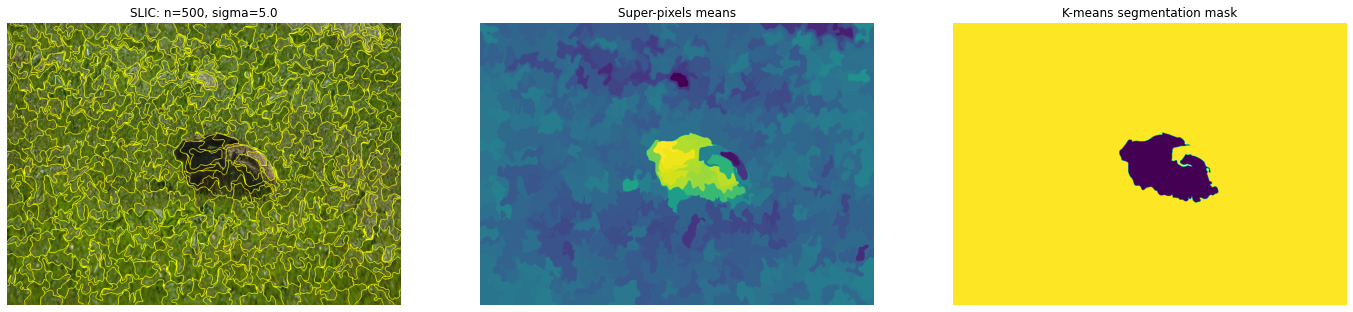

In [208]:
features = [slic_segmentation(hare, n, 5.0) for n in [100, 200, 300, 400, 500]]